<a href="https://colab.research.google.com/github/Nusserle/sentiment_learning/blob/master/conceptnet_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [1]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())
pool = mp.Pool(mp.cpu_count())

Number of processors:  4


In [0]:
!pip install git+https://github.com/crazyfrogspb/RedditScore.git
!sudo apt-get -o Dpkg::Options::="--force-confmiss" install --reinstall netbase
!python -c "import socket ; socket.getprotobyname('udp')"

In [3]:
import os
import random

import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
import numpy as np
import matplotlib.pyplot as plt
import csv
import re
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from redditscore.tokenizer import CrazyTokenizer

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Functions**

In [0]:
import re
rule0 = re.compile(r'\$&@\*#')
rule1 = re.compile(r"\s.*?twitter.*?\s")
rule2= re.compile(r'social_autopilot&utm_source')
rule3= re.compile(r'tweet&utm_medium')



def read_in(path_to_file):
    """
    Reads in training and test data and removes all neutral tweets
    from test data because the training data lacks neutral.
    Due to hardware restrictions we used only 1/10th of the available 
    training dataset (160.000 tweets)
    """
    out = []
    with open(path_to_file, encoding='latin-1') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader)
        for row in csv_reader:
            out.append([row[1], row[2]])
    return out

def read_in2(path_to_file):
  out = []
  with open(path_to_file, encoding='latin-1') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader)
        for row in csv_reader:
          if row.__len__() > 0:
            out.append([row[0], row[1]])
  return out


def preprocess(data):
    """
    Preprocesses and tokenizes data
    """
    label = []
    tweet = []
    lemmatizer = WordNetLemmatizer()
    tk = CrazyTokenizer(lowercase=True, keepcaps=False, normalize=2, ignore_quotes=False, ignore_reddit_quotes=False, ignore_stopwords='english', 
                        stem='lemm', remove_punct=True, remove_breaks=True, decontract=True, twitter_handles='', urls='url', hashtags='split', 
                        numbers=False, subreddits=False, reddit_usernames=False, emails=False, 
                        extra_patterns=[('rule0', rule0, 'stupid'), ('rule1', rule1, 'url'), ('rule2', rule2, ''), ('rule3', rule3, '')], 
                        keep_untokenized=None, whitespaces_to_underscores=True, 
                        remove_nonunicode=True, pos_emojis=True, neg_emojis=True, neutral_emojis=True, print_url_warnings=False, 
                        latin_chars_fix=True, ngrams=1)
    print("Preprocessing...")
    for i, row in enumerate(data):
      if i % 100 == 0:
        print(i)
      cleaned = clean_regex(row[1])
      if cleaned.__len__() > 1:
          if row[0] == "0":
              label.append(0)
          else:
              label.append(1)
          lemmatized = tk.tokenize(row[1])
          #tokenized = nltk.word_tokenize(cleaned)
          #lemmatized = []
          #for w in tokenized:
            #lemmatized.append(lemmatizer.lemmatize(w))
          # pos_tagged = nltk.pos_tag(tokenized)
          tweet.append(lemmatized)
    print("Done")
    return tweet, label

def preprocess2(data):
    """
    Preprocesses and tokenizes data
    """
    ids = []
    tweet = []
    lemmatizer = WordNetLemmatizer()
    tk = CrazyTokenizer(lowercase=True, keepcaps=False, normalize=2, ignore_quotes=False, ignore_reddit_quotes=False, ignore_stopwords='english', 
                        stem='lemm', remove_punct=True, remove_breaks=True, decontract=True, twitter_handles='', urls='url', hashtags='split', 
                        numbers=False, subreddits=False, reddit_usernames=False, emails=False, 
                        extra_patterns=[('rule0', rule0, 'stupid'), ('rule1', rule1, 'url'), ('rule2', rule2, ''), ('rule3', rule3, '')], 
                        keep_untokenized=None, whitespaces_to_underscores=True, 
                        remove_nonunicode=True, pos_emojis=True, neg_emojis=True, neutral_emojis=True, print_url_warnings=False, 
                        latin_chars_fix=True, ngrams=1)
    print("Preprocessing...")
    for i, row in enumerate(data):
      if i % 100 == 0:
        print(i)
      cleaned = clean_regex(row[1])
      if cleaned.__len__() > 1:
        lemmatized = tk.tokenize(row[1])

          #tokenized = nltk.word_tokenize(cleaned)
          #lemmatized = []
          #for w in tokenized:
            # lemmatized.append(lemmatizer.lemmatize(w))
          # pos_tagged = nltk.pos_tag(tokenized)
        tweet.append(lemmatized)
        ids.append(row[0])
    print("Done")
    return tweet, ids


def clean_regex(tweet):
    """
    Regex that removes links to other users, and all hyperlink mentions
    """
    hashtags = re.findall('#[a-z]*?[A-Z][A-Z|a-z]*', tweet)
    for hashtag in hashtags:
      replacement = ' '.join(re.sub( r"([A-Z])", r" \1", hashtag).split())
      tweet = tweet.replace(hashtag, replacement).lower()
    cleaned0 = re.sub('\$&@\*#', 'fuck', tweet)
    cleaned1 = re.sub('@.*?(?:\s|$)', '', cleaned0)
    cleaned2 = re.sub('http.*?(?:\s|$)', '', cleaned1)
    cleaned3 = re.sub('www.*?(?:\s|$)', '', cleaned2)
    cleaned4 = re.sub('#','', cleaned3)
    return cleaned4

def parse_to_dict(file_path):
    """
    Creates hashmap with word as key and concept vector as value
    :param file_path: path to the conceptnet dictionary file
    :return: hashmap of word and vectors
    """
    concept_hash = {}
    with open(file_path, encoding="utf8") as f:
        text = f.readlines()[1:]
        for line in text:
            first_item = line.split(" ").__getitem__(0)
            concept_hash[first_item] = line
    f.close()
    return concept_hash

def find_word(word, concept_hash):
    """
    Finds conceptnet vector for a word in the conceptnet hashmap
    :param word: input word to analyze
    :param concept_hash: hashmap of word and conceptnet vector
    :return: returns the appropriate vector or none if its not in the hashmap
    """
    if word in concept_hash.keys():
        vector = concept_hash[word].split(" ")[1:]
        vector = [float(i) for i in vector]
    else:
        vector = None
    return vector
  
def get_embeddings(sentences):
    """
    Retrieves a 300 dim. embedding vector from ConceptNet for each word 
    of a sentence. (Only retrieves the first 40 words (tokens) of a tweet)
    """
    sid = SentimentIntensityAnalyzer()
    maximum = 0
    max_words = 57
    results = np.zeros((len(sentences), max_words, 300))
    for i, sent in enumerate(sentences):
        if i % 25000 == 0:
            print(str(i))
        local_max = 0
        for j, word in enumerate(sent):
            if j < max_words:
                embedding = find_word(word.lower(), concept_hash)
                if embedding is not None:
                    local_max += 1
                    for k, val in enumerate(embedding):
                        results[i][j][k] = val
                else:
                    for k in range(300):
                        results[i][j][k] = 0.0
        #sentence_sentiment = sid.polarity_scores(' '.join(sent))['compound']
        #if sentence_sentiment > 0:
        #  results[i][57] = 1.0
        #elif sentence_sentiment < 0:
        #  results[i][57] = -1.0
        #else:
        #  results[i][57] = 0.0
        if maximum < local_max:
          maximum = local_max
    print(maximum)
    return results

def fill_list(data, max_dim=60):
  """
  Fills or cuts list of tokens for a tweet at 35, to ensure consistent vector dimensions
  """
  res = []
  for row in data:
      copy = row
      if len(row) < max_dim:
          copy += [''] * (max_dim - len(row))
      elif len(row) > max_dim:
          copy = row[:max_dim]   
      res.append(copy)
  return res

#def write_to_file(file_name, data, label):
#  f= open("preprocessed","w+")


In [5]:
from google.colab import files
files.upload()

Saving train_2kmZucJ.csv to train_2kmZucJ.csv
Saving test_oJQbWVk.csv to test_oJQbWVk.csv


{'test_oJQbWVk.csv': b'id,tweet\r\n7921,I hate the new #iphone upgrade. Won\'t let me download apps. #ugh #apple sucks\r\n7922,currently shitting my fucking pants. #apple #iMac #cashmoney #raddest #swagswagswag http://instagr.am/p/UUIS0bIBZo/\r\n7923,"I\'d like to puts some CD-ROMS on my iPad, is that possible?\' \xe2\x80\x94 Yes, but wouldn\'t that block the screen?\n"\r\n7924,"My ipod is officially dead. I lost all my pictures and videos from the 1D and 5sos concert,and from Vet Camp #hatinglife #sobbing"\r\n7925,Been fighting iTunes all night! I only want the music I $&@*# paid for\r\n7926,#Repost @getbakednfried with repostapp \xe3\x83\xbb\xe3\x83\xbb\xe3\x83\xbb to announce we will have our #apple #bourbon\xe2\x80\xa6 https://www.instagram.com/p/BK5okHOgWSS/\r\n7927,This new apple software update is really doing things to my phone. Bad things apple\r\n7928,BABY #iPhone #iphone6s #gold #new #apple #appleisbest #64GB #geg\xc3\xb6nnt #aaaaah https://www.instagram.com/p/BAUx8eQtKez/\r

In [0]:
!git clone https://github.com/HIT-SCIR/ELMoForManyLangs
!pip install allennlp
%cd ELMoForManyLangs/
%ls
!python setup.py install
!wget http://vectors.nlpl.eu/repository/11/144.zip
!unzip 144.zip
%rm "config.json"

In [0]:
from google.colab import files
files.upload()

Saving cnn_50_100_512_4096_sample.json to cnn_50_100_512_4096_sample.json
Saving config.json to config.json


{'cnn_50_100_512_4096_sample.json': b'{\r\n"encoder": {\r\n"name": "elmo",\r\n"projection_dim": 512,\r\n"cell_clip": 3,\r\n"proj_clip": 3,\r\n"dim": 4096,\r\n"n_layers": 2\r\n},\r\n\r\n"token_embedder": {\r\n\t"name": "cnn",\r\n\t"activation": "relu",\r\n\t"filters": [[1, 32], [2, 32], [3, 64], [4, 128], [5, 256], [6, 512], [7, 1024]],\r\n\t"n_highway": 2,\r\n\t"word_dim": 100,\r\n\t"char_dim": 50,\r\n\t"max_characters_per_token": 50\r\n},\r\n\r\n"classifier": {\r\n\t"name": "sampled_softmax",\r\n\t"n_samples": 8192\r\n},\r\n"dropout": 0.1\r\n}',
 'config.json': b'{"seed": 1, "gpu": 3, "train_path": "/users4/conll18st/raw_text/English/en-20m.raw", "valid_path": null, "test_path": null, "config_path": "cnn_50_100_512_4096_sample.json", "word_embedding": null, "optimizer": "adam", "lr": 0.001, "lr_decay": 0.8, "model": "/users4/conll18st/elmo/src/final_models/en.model", "batch_size": 32, "max_epoch": 10, "clip_grad": 5, "max_sent_len": 20, "min_count": 3, "max_vocab_size": 150000, "save_

In [0]:
%cd ..

/content


In [0]:
from elmoformanylangs import Embedder
e = Embedder('ELMoForManyLangs/')

In [0]:
%ls

sample_data/


In [0]:
pip install bert-embedding

In [0]:
from bert_embedding import BertEmbedding
bert_embedding = BertEmbedding()

In [0]:
bert_embedding(["This is a test sentence", "This as well"] )

**Preprocessing**

In [0]:
pool = mp.Pool(mp.cpu_count())
mp.cpu_count
#base_path = "C:/Users/Tobias.Nusser/PycharmProjects/sentiment_learning"
#base_path = os.getcwd()
# 140.000 entries
data = read_in("train_2kmZucJ.csv")
print(data.__len__())
data_1 = data[:2000]
data_2 = data[2000:4000]
data_3 = data[4000:6000]
data_4 = data[6000:]

res_data_1 = pool.apply_async(preprocess, args=(data_1,))
res_data_2 = pool.apply_async(preprocess, args=(data_2,))
res_data_3 = pool.apply_async(preprocess, args=(data_3,))
res_data_4 = pool.apply_async(preprocess, args=(data_4,))

t1, l1 = res_data_1.get()
t2, l2 = res_data_2.get()
t3, l3 = res_data_3.get()
t4, l4 = res_data_4.get()

training_data = t1 + t2 + t3 + t4
training_label = l1 + l2 + l3 + l4


#training_data = pool.apply_async(preprocess, args=(data,))
#output = training_data.get()
#training_data, training_label = 
#test_data, test_label = preprocess2(read_in2("test_oJQbWVk.csv"))
#print(training_data)

In [311]:
zipped = list(zip(training_data, training_label))
random.shuffle(zipped)
print(zipped)
training_data = []
training_label = []
for tup in zipped:
  training_data.append(tup[0])
  training_label.append(tup[1])

[(['well', 'hopefully', 'back', 'atlanta', 'time', 'computer', 'update', 'cool', 'apple', 'macbook', 'pro', 'url'], 1), (['wish', 'phone', 'die', 'time', 'damnit', 'samsung'], 1), (['calling', 'unemployment', 'people', 'love', 'tweeting', 'hold', 'time<3', 'iphone'], 0), (['need', 'valentine', 'day', 'iphone', 'wallpaper', 'check', '10', 'loveable', 'wallpaper', 'url', 'valentines', 'day', 'iphone', 'pic.twitter.com/swfm58d0gz'], 0), (['yay', 'finally', 'fixed', 'apple', 'issue', 'genius', 'could', 'help', 'url', 'jt2vn4xbpb'], 0), (['cubyrinth', 'iphone', 'ipad', 'puzzle', 'app', 'url', 'blog', 'puzzle', 'apps', 'rubik', 'puzzle', 'sudoku', 'app', 'iphone', 'ipad'], 0), (['budget', '2016', 'bare', 'minimum', 'budget', 'url', 'news', 'photography', 'fashion', 'health', 'fail', 'tech', 'ipad', 'iphone', 'funny', 'lol'], 0), (['go', 'gym', 'iphone', 'sia', 'insta', 'good', 'photo', 'of', 'the', 'day', 'twee', 'gram', 'iphone', 'iphone', 'only', 'ige', 'rs', 'cute', 'follow', 'me', 'url']

In [34]:
r_set = {}
for row in training_data:
  if row.__len__() not in r_set:
    r_set[row.__len__()] = 1
  else:
    r_set[row.__len__()] = r_set[row.__len__()] + 1
import operator
sorted_x = sorted(r_set.items(), key=operator.itemgetter(0), reverse=True)
print(sorted_x)

[(57, 2), (56, 2), (55, 1), (52, 1), (51, 2), (50, 2), (49, 4), (48, 1), (47, 6), (46, 5), (45, 7), (44, 6), (43, 10), (42, 14), (41, 11), (40, 15), (39, 15), (38, 21), (37, 30), (36, 29), (35, 37), (34, 39), (33, 47), (32, 30), (31, 38), (30, 48), (29, 36), (28, 28), (27, 33), (26, 32), (25, 39), (24, 59), (23, 45), (22, 61), (21, 73), (20, 140), (19, 252), (18, 247), (17, 379), (16, 588), (15, 728), (14, 761), (13, 746), (12, 844), (11, 647), (10, 558), (9, 445), (8, 335), (7, 194), (6, 139), (5, 50), (4, 31), (3, 5), (1, 1), (0, 1)]


In [0]:
dic = {}
for row in training_data:
  for entry in row:
    if entry not in dic:
      dic[entry] = 1
    else:
      dic[entry] = dic[entry] + 1
sorted_y = sorted(dic.items(), key=operator.itemgetter(1), reverse=True)
for x in sorted_y:
  print(x)

In [0]:
combined = training_data + test_data
dic = {}
for l in combined:
  for e in l:
    if e not in dic:
      dic[e] = 1
    else:
      dic[e] = dic[e] + 1
import operator
sorted_x = sorted(dic.items(), key=operator.itemgetter(1), reverse=True)

for entry in sorted_x:
  print(entry)

**Split into training and validation set**

In [0]:
split_at = 7000
train_data = training_data[:split_at]
train_label = np.asarray(training_label[:split_at])
val_data = training_data[split_at:]
val_label = np.asarray(training_label[split_at:])

In [0]:
train_embedding_matrix = np.asarray(e.sents2elmo(fill_list(train_data)))
val_embedding_matrix = np.asarray(e.sents2elmo(fill_list(val_data)))

In [0]:
out_array = np.zeros(shape=(train_data.__len__(),10,768))
for i, row in enumerate(train_data):
  if i % 5 == 0:
    print(i)
  vec = bert_embedding(row)
  for j, word_vec in enumerate(vec):
    if j < 10:
      out_array[i][j] = word_vec[1][0]
  #print(type(bert_embedding(row)[0]))
#train_embedding_matrix = bert_embedding(fill_list(train_data))
#val_embedding_matrix = bert_embedding(fill_list(val_data))

In [0]:

file = !wget https://conceptnet.s3.amazonaws.com/downloads/2017/numberbatch/numberbatch-en-17.06.txt.gz
  
import gzip
import shutil
with gzip.open("numberbatch-en-17.06.txt.gz",'rb') as f_in:
    with open('numberbatch-en.txt','wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

**Load ConceptNet word embeddings in RAM**

In [0]:
concept_hash = parse_to_dict("numberbatch-en.txt")

**Retrieve word embedding vectors for training and validation data**

In [313]:
train_embedding_matrix = get_embeddings(train_data)
val_embedding_matrix = get_embeddings(val_data)

0
54
0
43


In [0]:
elmo_train_embedding_matrix = train_embedding_matrix
elmo_val_embedding_matrix = val_embedding_matrix

In [247]:
print(train_embedding_matrix[5][57][299])
print(train_embedding_matrix[0][0].__len__())
print(train_embedding_matrix.shape)
print(val_embedding_matrix.shape)

-1.0
300
(7000, 58, 300)
(920, 58, 300)


In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')



**Neural Network Model**

Sequential model with three Dense Layers and one Flatten layer to flatten 3D input matrix.
*Relu* as activation function and simple *sigmoid* function for the output layer. Because of the binary classification task we used a simple *accuracy* metric and *binary crossentropy* as loss function. As optimizer we used *rmsprop*, which performed best according to some tests.

In [323]:
from keras.callbacks import ModelCheckpoint

model = models.Sequential()
model.add(layers.LSTM(58, activation='tanh' ,input_shape=(57,300,)))
#model.add(layers.GRU(62, activation='tanh', input_shape=(57,300,)))
#model.add(layers.Flatten())
model.add(layers.Dense(58, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=0.00205),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['acc'])
print(model.summary())
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(train_embedding_matrix,
                    train_label,
                    epochs=75,
                    batch_size=512,
                    validation_data=(val_embedding_matrix, val_label), verbose=1, callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 58)                83288     
_________________________________________________________________
dense_54 (Dense)             (None, 58)                3422      
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 59        
Total params: 86,769
Trainable params: 86,769
Non-trainable params: 0
_________________________________________________________________
None
Train on 7000 samples, validate on 920 samples
Epoch 1/75
7000/7000 [==============================] - 9s 1ms/step - loss: 0.6106 - acc: 0.7427 - val_loss: 0.5475 - val_acc: 0.7522

Epoch 00001: val_acc improved from -inf to 0.75217, saving model to weights.best.hdf5
Epoch 2/75
7000/7000 [==============================] - 3s 382us/step - loss: 0.4685 - acc: 0.7431 - val_loss: 0.3256 - val_acc: 

**Plotting accuracy and loss in the training phase**

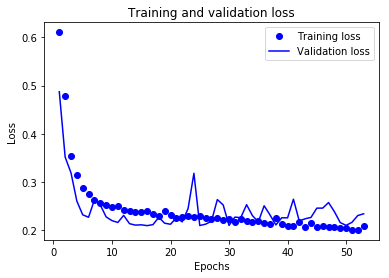

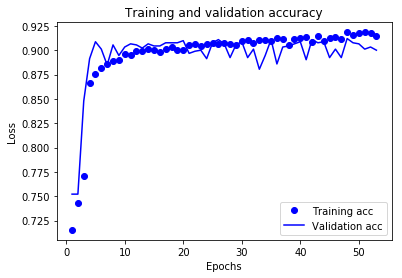

In [315]:
# Loss plot
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy plot
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Evaluating model on test data**

In [0]:
test_label = np.asarray(test_label)
#test_embedding_matrix = get_embeddings(test_data)
test_embedding_matrix = np.asarray(e.sents2elmo(fill_list(test_data)))
results = model.evaluate(test_embedding_matrix, test_label)
print("Loss: ", results[0])
print("Accuracy: ", results[1])

359/359 [==============================] - 0s 140us/step
Loss:  0.6674792934260992
Accuracy:  0.7047353763766275


In [0]:
elmo_test_embedding_matrix = test_embedding_matrix

In [0]:
test_data, test_id = preprocess2(read_in2("test_oJQbWVk.csv"))

#test_embedding_matrix = np.asarray(e.sents2elmo(fill_list(test_data)))
print(test_embedding_matrix.shape)

Preprocessing...
Done
0
(1953, 60, 300)


In [75]:
test_embedding_matrix = get_embeddings(test_data)

0


In [114]:
pool = mp.Pool(mp.cpu_count())
mp.cpu_count
test_data = read_in2("test_oJQbWVk.csv")
print(test_data.__len__())
test_1 = test_data[:500]
test_2 = test_data[500:1000]
test_3 = test_data[1000:1500]
test_4 = test_data[1500:]

res_test_1 = pool.apply_async(preprocess2, args=(test_1,))
res_test_2 = pool.apply_async(preprocess2, args=(test_2,))
res_test_3 = pool.apply_async(preprocess2, args=(test_3,))
res_test_4 = pool.apply_async(preprocess2, args=(test_4,))

t1, l1 = res_test_1.get()
t2, l2 = res_test_2.get()
t3, l3 = res_test_3.get()
t4, l4 = res_test_4.get()

test_data = t1 + t2 + t3 + t4
test_label = l1 + l2 + l3 + l4

1953
Preprocessing...
0
Preprocessing...
Preprocessing...
Preprocessing...
0
0
0
100
100
100
100
200
200
200
200
300
300
300
300
400
400
400
400
Done
Done
Done
Done


In [298]:
test_embedding_matrix = get_embeddings(test_data)

0
55


In [0]:
model.load_weights("weights.best.hdf5")

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                278784    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 283,009
Trainable params: 283,009
Non-trainable params: 0
_________________________________________________________________


In [0]:
prediction = model.predict(test_embedding_matrix)

In [0]:
print(output)

[['1', '7921'], ['0', '7922'], ['1', '7923'], ['0', '7924'], ['1', '7925'], ['0', '7926'], ['1', '7927'], ['0', '7928'], ['1', '7929'], ['0', '7930'], ['0', '7931'], ['0', '7932'], ['0', '7933'], ['0', '7934'], ['0', '7935'], ['0', '7936'], ['0', '7937'], ['1', '7938'], ['1', '7939'], ['0', '7940'], ['0', '7941'], ['0', '7942'], ['0', '7943'], ['0', '7944'], ['1', '7945'], ['0', '7946'], ['0', '7947'], ['0', '7948'], ['1', '7949'], ['0', '7950'], ['1', '7951'], ['1', '7952'], ['0', '7953'], ['0', '7954'], ['0', '7955'], ['1', '7956'], ['1', '7957'], ['0', '7958'], ['0', '7959'], ['0', '7960'], ['0', '7961'], ['0', '7962'], ['0', '7963'], ['0', '7964'], ['0', '7965'], ['0', '7966'], ['0', '7967'], ['0', '7968'], ['0', '7969'], ['1', '7970'], ['1', '7971'], ['0', '7972'], ['0', '7973'], ['0', '7974'], ['0', '7975'], ['0', '7976'], ['1', '7977'], ['0', '7978'], ['0', '7979'], ['1', '7980'], ['0', '7981'], ['0', '7982'], ['0', '7983'], ['0', '7984'], ['0', '7985'], ['0', '7986'], ['0', '79

In [0]:
output = []
for i, pred in enumerate(prediction):
  if pred > 0.5:
    output.append([test_label[i], "1"])
  else:
    output.append([test_label[i], "0"])
with open('output.csv', 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerow(["id", "label"])
    writer.writerows(output)


In [331]:
%ls
from google.colab import files
files.download('output.csv')

numberbatch-en-17.06.txt.gz  output.csv    test_oJQbWVk.csv   weights.best.hdf5
numberbatch-en.txt           sample_data/  train_2kmZucJ.csv


**Results**

We trained our network on 140.000 samples (120.000 training and 20.000 validation samples) and used the word embedding vectors obtained by ConceptNet. Unfortunately, due to hardware limitations, this is less than a 10th of the available training data. However, as we tested the model with multiple random subsets of the 1.6M samples we achieved accuracies in-between 78%-82%, and therefore perform as good as several state-of-the-art approaches [Go et al.](https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf), [Ebert et al.](https://www.aclweb.org/anthology/W15-2915). Accuracy and loss improve until epoch 6-10 and more or less stagnate until epoch 20.